## Pytorch SegNet and DeepLabV3 Implementation
**Please upvote if this notebook is useful **

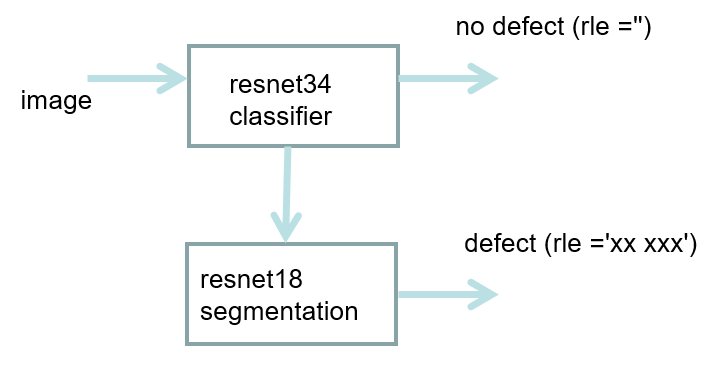
After Resnet34 Classifier Training ( https://www.kaggle.com/robinreni/heng-s-pytorch-resnet34-classifier-training ) we have to train our segmentation module

In [ ]:
import cv2
import collections
import os
import numpy as np
import matplotlib.pyplot as plt
import random

from PIL import Image, ImageFile
import pandas as pd
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from ipywidgets import IntProgress
from torch.autograd import Variable

import torch.utils.data
from torchvision import models
from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader, Dataset, sampler
#torch.backends.cudnn.enabled = False

In [ ]:
# Checking python versions
import platform
print(f'Python version: {platform.python_version()}')
print(f'PyTorch version: {torch.__version__}')

In [ ]:
# Read csv
train = pd.read_csv("/kaggle/input/severstal-steel-defect-detection/train.csv")
train.head()

In [ ]:
train_defect = train[train['EncodedPixels'].notnull()]
train_defect = train_defect.reset_index(drop=True)
train_defect = train_defect[:2000] # Loading only 2000 samples to check whether flow is correct
train_defect.head()

### Mask Decoder :
To mask the images from the given encodings 

In [ ]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

### Visualize data 

In [ ]:
columns = 1
rows = 4
fig = plt.figure(figsize=(20,columns*rows+6))
for i in range(1,columns*rows+1):
    fn = train_defect['ImageId_ClassId'].str[:-2].iloc[i]
    fig.add_subplot(rows, columns, i).set_title(fn)
    img = cv2.imread( '/kaggle/input/severstal-steel-defect-detection/train_images/'+fn )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask(train_defect['EncodedPixels'].iloc[i], (256, 1600))
    img[mask==1,0] = 255
    plt.imshow(img)
plt.show()

### DataSet and DataLoader

In [ ]:
class ImageData(Dataset):
    def __init__(self, df, transform, subset="train"):
        super().__init__()
        self.df = df
        self.transform = transform
        self.subset = subset
        
        if self.subset == "train":
            self.data_path = '/kaggle/input/severstal-steel-defect-detection/train_images/'
        elif self.subset == "test":
            self.data_path = "/kaggle/input/severstal-steel-defect-detection/test_images/"
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        fn = self.df["ImageId_ClassId"].iloc[index].split('_')[0]
        img = Image.open(self.data_path + fn)
        img = self.transform(img)
        
        if self.subset == "train":
            mask = rle2mask(self.df["EncodedPixels"].iloc[index], (256, 1600))
            mask = transforms.ToPILImage()(mask)
            mask = self.transform(mask)
            return img,mask
        else:
            mask = None
            return img

In [ ]:
data_transf = transforms.Compose([
                                    transforms.Resize((256,800)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485], std=[0.229])
])
train_data = ImageData(df= train_defect, transform = data_transf )


#### Loss Function :
Since they mentioned to use dice loss explicitly we are using it for the segmentation

In [ ]:
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        
    def forward(self, logits, targets):
        
        N = targets.size(0)
        preds = torch.sigmoid(logits)
        
        EPSILON = 1e-7
        
        # Flattening the final layer 
        preds_flat = preds.view(N,-1)
        targets_flat = targets.view(N, -1)
        
        intersection = (preds_flat * targets_flat).sum()
        union = (preds_flat + targets_flat).sum()
        
        loss = (2.0 * intersection + EPSILON) / (union + EPSILON)
        loss = 1 - loss / N
        return loss

### Train Function

In [ ]:
# To start with optmized learning rate
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

In [ ]:
# train function
def train(model, optimizer, data_loader, device, epoch):
    model.train()
    loss_func = DiceLoss() #nn.BCEWithLogitsLoss() 

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    lossf=None
    inner_tq = tqdm(data_loader, total=len(data_loader), leave=False, desc= f'Epoch: {epoch+1}')
    for images, masks in inner_tq:
        y_preds = model.forward(images.to(device))
        # For Segnet
        y_preds = y_preds[:, 1, :, :] 
        # For DeepLab V3
#         y_preds = y_preds['out'][:, 1, :, :] 

        loss = loss_func(y_preds, masks.to(device))

        if torch.cuda.device_count() > 1:
            loss = loss.mean() # mean() to average on multi-gpu.

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if lr_scheduler is not None:
            lr_scheduler.step()

        if lossf:
            lossf = 0.98*lossf+0.02*loss.item()
        else:
            lossf = loss.item()
        inner_tq.set_postfix(loss = lossf)

In [ ]:
!wget 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth'

In [ ]:
# Model Definition

def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()
                
class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers):
        super(_DecoderBlock, self).__init__()
        middle_channels = int(in_channels / 2)
        layers = [
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2),
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True)
        ]
        layers += [
                      nn.Conv2d(middle_channels, middle_channels, kernel_size=3, padding=1),
                      nn.BatchNorm2d(middle_channels),
                      nn.ReLU(inplace=True),
                  ] * (num_conv_layers - 2)
        layers += [
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        self.decode = nn.Sequential(*layers)

    def forward(self, x):
        return self.decode(x)


class SegNet(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(SegNet, self).__init__()
        vgg = models.vgg19_bn()
        vgg19_bn_path = "vgg19_bn-c79401a0.pth"
        if pretrained:
            vgg.load_state_dict(torch.load(vgg19_bn_path))
        vgg = vgg.cuda()
        features = list(vgg.features.children())
        self.enc1 = nn.Sequential(*features[0:7])
        self.enc2 = nn.Sequential(*features[7:14])
        self.enc3 = nn.Sequential(*features[14:27])
        self.enc4 = nn.Sequential(*features[27:40])
        self.enc5 = nn.Sequential(*features[40:])

        self.dec5 = nn.Sequential(
            *([nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)] +
              [nn.Conv2d(512, 512, kernel_size=3, padding=1),
               nn.BatchNorm2d(512),
               nn.ReLU(inplace=True)] * 4)
        )
        self.dec4 = _DecoderBlock(1024, 256, 4)
        self.dec3 = _DecoderBlock(512, 128, 4)
        self.dec2 = _DecoderBlock(256, 64, 2)
        self.dec1 = _DecoderBlock(128, num_classes, 2)
        initialize_weights(self.dec5, self.dec4, self.dec3, self.dec2, self.dec1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)

        dec5 = self.dec5(enc5)
        dec4 = self.dec4(torch.cat([enc4, dec5], 1))
        dec3 = self.dec3(torch.cat([enc3, dec4], 1))
        dec2 = self.dec2(torch.cat([enc2, dec3], 1))
        dec1 = self.dec1(torch.cat([enc1, dec2], 1))
        return nn.Parameter(dec1)

In [ ]:
# Model Declaration 
#SegNet
model_ft = SegNet(num_classes=4,pretrained=False)

# DeeplabV3
# model_ft = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=False, num_classes=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_ = model_ft.to(device)

In [ ]:
# train DataLoader
NUM_GPUS = torch.cuda.device_count()
if NUM_GPUS > 1:
    model_ft = torch.nn.DataParallel(model_ft)
data_loader = DataLoader(train_data, batch_size = 8, shuffle = True,
                         num_workers = NUM_GPUS)

In [ ]:
# Optimizer 
params = [p for p in model_ft.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.001, momentum = 0.9 , weight_decay = 0.0005)

In [ ]:
# Learning Scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1 )

In [ ]:
num_epochs = 2
for epoch in range(num_epochs):
    train(model_ft, optimizer, data_loader, device, epoch)
    lr_scheduler.step()

In [ ]:
# Save the model 
torch.save(model_ft.state_dict(),"model_seg_last.pth")

In [ ]:
# Loading and check the model
# SegNet
model = SegNet(num_classes = 4)

# DeepLabV3
# model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=False, num_classes=4)

model.load_state_dict(torch.load("model_seg_last.pth"))
model.eval()

A Huge thanks to the author of  https://www.kaggle.com/mobassir/deeplabv3-resnet101-for-severstal-sdd .